Deep Learning
=============

Assignment 2
------------

Previously in `1_notmnist.ipynb`, we created a pickle with formatted datasets for training, development and testing on the [notMNIST dataset](http://yaroslavvb.blogspot.com/2011/09/notmnist-dataset.html).

The goal of this assignment is to progressively train deeper and more accurate models using TensorFlow.

In [15]:
# These are all the modules we'll be using later. Make sure you can import them
# before proceeding further.
from __future__ import print_function
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from six.moves import cPickle as pickle
from six.moves import range

# Config the matlotlib backend as plotting inline in IPython
%matplotlib inline

First reload the data we generated in `1_notmnist.ipynb`.

In [3]:
pickle_file = 'notMNIST.pickle'

with open(pickle_file, 'rb') as f:
  save = pickle.load(f)
  train_dataset = save['train_dataset']
  train_labels = save['train_labels']
  valid_dataset = save['valid_dataset']
  valid_labels = save['valid_labels']
  test_dataset = save['test_dataset']
  test_labels = save['test_labels']
  del save  # hint to help gc free up memory
  print('Training set', train_dataset.shape, train_labels.shape)
  print('Validation set', valid_dataset.shape, valid_labels.shape)
  print('Test set', test_dataset.shape, test_labels.shape)

Training set (200000, 28, 28) (200000,)
Validation set (10000, 28, 28) (10000,)
Test set (10000, 28, 28) (10000,)


Reformat into a shape that's more adapted to the models we're going to train:
- data as a flat matrix,
- labels as float 1-hot encodings.

In [4]:
image_size = 28
num_labels = 10

def reformat(dataset, labels):
  dataset = dataset.reshape((-1, image_size * image_size)).astype(np.float32)
  # Map 0 to [1.0, 0.0, 0.0 ...], 1 to [0.0, 1.0, 0.0 ...]
  labels = (np.arange(num_labels) == labels[:,None]).astype(np.float32)
  return dataset, labels
train_dataset, train_labels = reformat(train_dataset, train_labels)
valid_dataset, valid_labels = reformat(valid_dataset, valid_labels)
test_dataset, test_labels = reformat(test_dataset, test_labels)
print('Training set', train_dataset.shape, train_labels.shape)
print('Validation set', valid_dataset.shape, valid_labels.shape)
print('Test set', test_dataset.shape, test_labels.shape)

Training set (200000, 784) (200000, 10)
Validation set (10000, 784) (10000, 10)
Test set (10000, 784) (10000, 10)


#### Helper functions

In [23]:
def plot_loss(x, y):
  plt.figure(figsize=(16, 4))
  plt.plot(x, y)
  plt.xlabel("Step")
  plt.ylabel("Loss")

def accuracy(predictions, labels):
  return (100.0 * np.sum(np.argmax(predictions, 1) == np.argmax(labels, 1))
          / predictions.shape[0])

## Multinomial Logistic Regression

We're first going to train a multinomial logistic regression using simple gradient descent.

TensorFlow works like this:
* First you describe the computation that you want to see performed: what the inputs, the variables, and the operations look like. These get created as nodes over a computation graph. This description is all contained within the block below:

      with graph.as_default():
          ...

* Then you can run the operations on this graph as many times as you want by calling `session.run()`, providing it outputs to fetch from the graph that get returned. This runtime operation is all contained in the block below:

      with tf.Session(graph=graph) as session:
          ...

Let's load all the data into TensorFlow and build the computation graph corresponding to our training:

In [24]:
# With gradient descent training, even this much data is prohibitive.
# Subset the training data for faster turnaround.
train_subset = 10000

graph = tf.Graph()
with graph.as_default():

  # Input data.
  # Load the training, validation and test data into constants that are
  # attached to the graph.
  # 'tf.constant' Creates a constant tensor.
  tf_train_dataset = tf.constant(train_dataset[:train_subset, :])
  tf_train_labels = tf.constant(train_labels[:train_subset])
  tf_valid_dataset = tf.constant(valid_dataset)
  tf_test_dataset = tf.constant(test_dataset)
  
  # Variables.
  # These are the parameters that we are going to be training. The weight
  # matrix will be initialized using random valued following a (truncated)
  # normal distribution. The biases get initialized to zero.
  weights = tf.Variable(
    tf.truncated_normal([image_size * image_size, num_labels]))
  biases = tf.Variable(tf.zeros([num_labels]))
  
  # Training computation.
  # We multiply the inputs with the weight matrix, and add biases. We compute
  # the softmax and cross-entropy (it's one operation in TensorFlow, because
  # it's very common, and it can be optimized). We take the average of this
  # cross-entropy across all training examples: that's our loss.
  logits = tf.matmul(tf_train_dataset, weights) + biases
  loss = tf.reduce_mean(
    tf.nn.softmax_cross_entropy_with_logits(logits, tf_train_labels))
  
  # Optimizer.
  # We are going to find the minimum of this loss using gradient descent.
  optimizer = tf.train.GradientDescentOptimizer(0.5).minimize(loss)
  
  # Predictions for the training, validation, and test data.
  # These are not part of training, but merely here so that we can report
  # accuracy figures as we train.
  train_prediction = tf.nn.softmax(logits)
  valid_prediction = tf.nn.softmax(
    tf.matmul(tf_valid_dataset, weights) + biases)
  test_prediction = tf.nn.softmax(tf.matmul(tf_test_dataset, weights) + biases)

Let's run this computation and iterate:

In [25]:
num_steps = 801

xx = []
yy = []
with tf.Session(graph=graph) as session:
  # This is a one-time operation which ensures the parameters get initialized as
  # we described in the graph: random weights for the matrix, zeros for the
  # biases. 
  tf.initialize_all_variables().run()
  print('Initialized')
  for step in range(num_steps):
    # Run the computations. We tell .run() that we want to run the optimizer,
    # and get the loss value and the training predictions returned as numpy
    # arrays.
    _, l, predictions = session.run([optimizer, loss, train_prediction])
    if (step % 20 == 0):
      xx.append(step)
      yy.append(l)

    if (step % 100 == 0):
      print('Loss at step %d: %f' % (step, l))
      print('Training accuracy: %.1f%%' % accuracy(
        predictions, train_labels[:train_subset, :]))
      # Calling .eval() on valid_prediction is basically like calling run(), but
      # just to get that one numpy array. Note that it recomputes all its graph
      # dependencies.
      print('Validation accuracy: %.1f%%' % accuracy(valid_prediction.eval(), valid_labels))
  print('Test accuracy: %.1f%%' % accuracy(test_prediction.eval(), test_labels))

Initialized
Loss at step 0: 18.022881
Training accuracy: 8.1%
Validation accuracy: 11.1%
Loss at step 100: 2.363165
Training accuracy: 71.9%
Validation accuracy: 70.0%
Loss at step 200: 1.896434
Training accuracy: 74.8%
Validation accuracy: 72.5%
Loss at step 300: 1.646310
Training accuracy: 76.2%
Validation accuracy: 73.2%
Loss at step 400: 1.475734
Training accuracy: 77.1%
Validation accuracy: 73.7%
Loss at step 500: 1.347317
Training accuracy: 77.8%
Validation accuracy: 73.8%
Loss at step 600: 1.246205
Training accuracy: 78.3%
Validation accuracy: 74.1%
Loss at step 700: 1.164557
Training accuracy: 78.8%
Validation accuracy: 74.2%
Loss at step 800: 1.097100
Training accuracy: 79.1%
Validation accuracy: 74.4%
Test accuracy: 82.0%


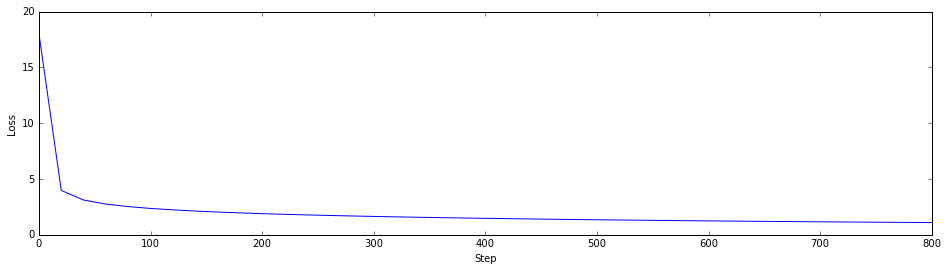

In [26]:
plot_loss(xx, yy)

### Stochastic gradient descent
Let's now switch to stochastic gradient descent training instead, which is much faster.

The graph will be similar, except that instead of holding all the training data into a constant node, we create a `Placeholder` node which will be fed actual data at every call of `session.run()`.

In [27]:
batch_size = 128

graph = tf.Graph()
with graph.as_default():

  # Input data. For the training data, we use a placeholder that will be fed
  # at run time with a training minibatch.
  tf_train_dataset = tf.placeholder(tf.float32,
                                    shape=(batch_size, image_size * image_size))
  tf_train_labels = tf.placeholder(tf.float32, shape=(batch_size, num_labels))
  tf_valid_dataset = tf.constant(valid_dataset)
  tf_test_dataset = tf.constant(test_dataset)
  
  # Variables.
  weights = tf.Variable(
    tf.truncated_normal([image_size * image_size, num_labels]))
  biases = tf.Variable(tf.zeros([num_labels]))
  
  # Training computation.
  logits = tf.matmul(tf_train_dataset, weights) + biases
  loss = tf.reduce_mean(
    tf.nn.softmax_cross_entropy_with_logits(logits, tf_train_labels))
  
  # Optimizer.
  optimizer = tf.train.GradientDescentOptimizer(0.5).minimize(loss)
  
  # Predictions for the training, validation, and test data.
  train_prediction = tf.nn.softmax(logits)
  valid_prediction = tf.nn.softmax(tf.matmul(tf_valid_dataset, weights) + biases)
  test_prediction = tf.nn.softmax(tf.matmul(tf_test_dataset, weights) + biases)

Let's run it:

Initialized
Minibatch loss at step 0: 14.796261
Minibatch accuracy: 8.6%
Validation accuracy: 19.4%
Minibatch loss at step 500: 1.125306
Minibatch accuracy: 80.5%
Validation accuracy: 75.7%
Minibatch loss at step 1000: 1.393882
Minibatch accuracy: 81.2%
Validation accuracy: 76.1%
Minibatch loss at step 1500: 0.841321
Minibatch accuracy: 78.1%
Validation accuracy: 77.2%
Minibatch loss at step 2000: 0.834419
Minibatch accuracy: 85.2%
Validation accuracy: 77.5%
Minibatch loss at step 2500: 0.795760
Minibatch accuracy: 78.9%
Validation accuracy: 78.2%
Minibatch loss at step 3000: 0.848836
Minibatch accuracy: 75.8%
Validation accuracy: 78.7%
Test accuracy: 86.4%


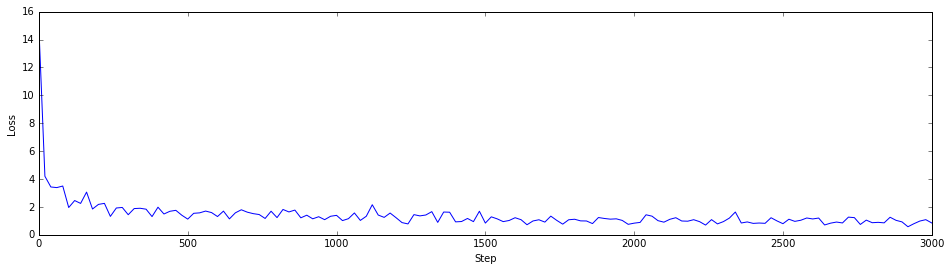

In [28]:
num_steps = 3001

xx = []
yy = []
with tf.Session(graph=graph) as session:
  tf.initialize_all_variables().run()
  print("Initialized")
  for step in range(num_steps):
    # Pick an offset within the training data, which has been randomized.
    # Note: we could use better randomization across epochs.
    offset = (step * batch_size) % (train_labels.shape[0] - batch_size)

    # Generate a minibatch.
    batch_data = train_dataset[offset:(offset + batch_size), :]
    batch_labels = train_labels[offset:(offset + batch_size), :]

    # Prepare a dictionary telling the session where to feed the minibatch.
    # The key of the dictionary is the placeholder node of the graph to be fed,
    # and the value is the numpy array to feed to it.
    feed_dict = {tf_train_dataset : batch_data, tf_train_labels : batch_labels}

    _, l, predictions = session.run(
      [optimizer, loss, train_prediction], feed_dict=feed_dict)

    if (step % 20 == 0):
        xx.append(step)
        yy.append(l)

    if (step % 500 == 0):
      print("Minibatch loss at step %d: %f" % (step, l))
      print("Minibatch accuracy: %.1f%%" % accuracy(predictions, batch_labels))
      print("Validation accuracy: %.1f%%" % accuracy(valid_prediction.eval(), valid_labels))

  print("Test accuracy: %.1f%%" % accuracy(test_prediction.eval(), test_labels))

plot_loss(xx, yy)

> Interesting to note that the graph is not smooth like before, but very irregular. This is because we calculate the gradients of several small random batches and optimize that as we go

---
Problem
-------

Turn the logistic regression example with SGD into a **1-hidden layer neural network** with rectified linear units [nn.relu()](https://www.tensorflow.org/versions/r0.7/api_docs/python/nn.html#relu) and 1024 hidden nodes. This model should improve your validation / test accuracy.

---

## Solution


In [29]:
batch_size = 128
hidden_units = 1024 # Size of the hidden layer

def accuracy(predictions, labels):
  return (100.0 * np.sum(np.argmax(predictions, 1) == np.argmax(labels, 1))
          / predictions.shape[0])

graph = tf.Graph()
with graph.as_default() as g:
  # Input data. For the training data, we use a placeholder that will be fed
  # at run time with a training minibatch.
  tf_train_dataset = tf.placeholder(tf.float32,
                                    shape=(batch_size, image_size * image_size))
  tf_train_labels = tf.placeholder(tf.float32, shape=(batch_size, num_labels))
  tf_valid_dataset = tf.constant(valid_dataset)
  tf_test_dataset = tf.constant(test_dataset)

  # Hidden Layer
  with g.name_scope("hidden"):
    weights1 = tf.Variable(
        tf.truncated_normal([image_size * image_size, hidden_units]),
        name='weights1')
    biases1 = tf.Variable(tf.zeros([hidden_units]), name='biases')
  
  # Linear
  with g.name_scope("softmax_linear"):
    weights2 = tf.Variable(
        tf.truncated_normal([hidden_units, num_labels]),
        name='weights2')
    biases2 = tf.Variable(tf.zeros([num_labels]), name='biases')
  
  def forward_prop(inp):
    return tf.matmul(
        tf.nn.relu(tf.matmul(inp, weights1) + biases1), weights2) + biases2  

  logits = forward_prop(tf_train_dataset)

  loss = tf.reduce_mean(
    tf.nn.softmax_cross_entropy_with_logits(logits, tf_train_labels))
  
  # Optimizer.
  optimizer = tf.train.GradientDescentOptimizer(0.5).minimize(loss)


  # Predictions for the training, validation, and test data.
  train_prediction = tf.nn.softmax(logits)
  valid_prediction = tf.nn.softmax(forward_prop(tf_valid_dataset))
  test_prediction = tf.nn.softmax(forward_prop(tf_test_dataset))

Initialized
Minibatch loss at step 0: 356.717224
Minibatch accuracy: 7.0%
Validation accuracy: 24.1%
Minibatch loss at step 500: 21.636883
Minibatch accuracy: 80.5%
Validation accuracy: 79.6%
Minibatch loss at step 1000: 12.294333
Minibatch accuracy: 80.5%
Validation accuracy: 81.7%
Minibatch loss at step 1500: 5.224451
Minibatch accuracy: 85.9%
Validation accuracy: 81.0%
Minibatch loss at step 2000: 3.565652
Minibatch accuracy: 85.9%
Validation accuracy: 81.6%
Minibatch loss at step 2500: 3.213212
Minibatch accuracy: 89.1%
Validation accuracy: 82.4%
Minibatch loss at step 3000: 1.814184
Minibatch accuracy: 83.6%
Validation accuracy: 83.0%
Test accuracy: 90.1%


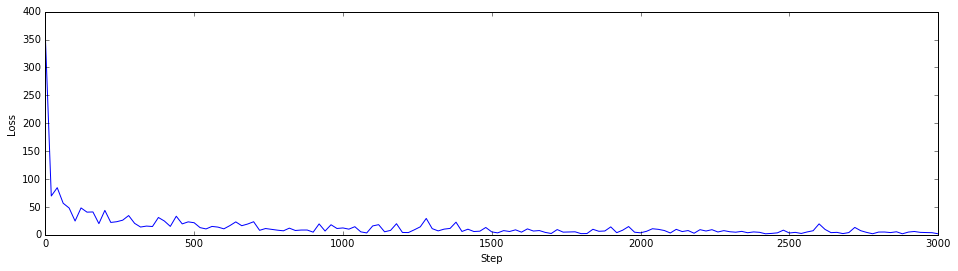

In [30]:
num_steps = 3001

xx = []
yy = []
with tf.Session(graph=graph) as session:
  tf.initialize_all_variables().run()
  print("Initialized")
  for step in range(num_steps):
    # Pick an offset within the training data, which has been randomized.
    # Note: we could use better randomization across epochs.
    offset = (step * batch_size) % (train_labels.shape[0] - batch_size)

    # Generate a minibatch.
    batch_data = train_dataset[offset:(offset + batch_size), :]
    batch_labels = train_labels[offset:(offset + batch_size), :]

    # Prepare a dictionary telling the session where to feed the minibatch.
    # The key of the dictionary is the placeholder node of the graph to be fed,
    # and the value is the numpy array to feed to it.
    feed_dict = {tf_train_dataset : batch_data, tf_train_labels : batch_labels}

    _, l, predictions = session.run(
      [optimizer, loss, train_prediction], feed_dict=feed_dict)

    if (step % 20 == 0):
        xx.append(step)
        yy.append(l)

    if (step % 500 == 0):
      print("Minibatch loss at step %d: %f" % (step, l))
      print("Minibatch accuracy: %.1f%%" % accuracy(predictions, batch_labels))
      print("Validation accuracy: %.1f%%" % accuracy(valid_prediction.eval(), valid_labels))

  print("Test accuracy: %.1f%%" % accuracy(test_prediction.eval(), test_labels))
  plot_loss(xx, yy)